In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go

from prophet import Prophet
from autots import AutoTS
from sklearn.metrics import mean_squared_error, mean_squared_error
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '../dasatet_5/BritishMart.csv'

bm = pd.read_csv(path)
pd.set_option('display.max_colwidth', None)

In [3]:
# Map sesuai perubahan
unit_mapping = {'kg': 'kg', 'l': 'litre', 'unit': 'ounces', 'm': 'meter'}

bm['unit'] = bm['unit'].replace(unit_mapping)

In [4]:
bm_empty = bm[bm.isna().any(axis=1)]

In [5]:
bm_empty

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal


In [6]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979866 entries, 0 to 979865
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   nama_toko       979866 non-null  object 
 1   harga_pound     979866 non-null  float64
 2   harga_per_unit  979866 non-null  float64
 3   unit            979866 non-null  object 
 4   nama            979866 non-null  object 
 5   kategori        979866 non-null  object 
 6   brand_sendiri   979866 non-null  bool   
 7   tanggal         979866 non-null  object 
dtypes: bool(1), float64(2), object(5)
memory usage: 53.3+ MB


# Standarisasi 'kategori'

In [7]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal
1,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-01-01
16332,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-20
36698,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-02-13
60982,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-03-13
89688,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-04-16
109517,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-05-10
125376,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-05-28
152528,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-06-29
167763,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-07-17
189559,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-08-12


In [8]:
mode_kategori = bm.groupby('nama')['kategori'].agg(lambda x: x.mode()[0])
bm = pd.merge(bm, mode_kategori, how='left', on='nama', suffixes=('', '_mode'))
bm['kategori'] = bm['kategori_mode']
bm.drop(columns=['kategori_mode'], inplace=True)

In [9]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal
1,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-01
16332,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-20
36698,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-02-13
60982,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-03-13
89688,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-04-16
109517,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-05-10
125376,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-05-28
152528,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-06-29
167763,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-07-17
189559,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-08-12


In [10]:
def recategorize(data):
    if data['brand_sendiri'] == True:
        return 1
    return 0

In [11]:
bm['brand_sendiri'] = bm.apply(recategorize, axis=1)

In [12]:
bm_cleaned = bm.loc[:,['harga_per_unit', 'nama', 'kategori', 'tanggal', 'brand_sendiri']]
bm_cleaned['tanggal'] = pd.to_datetime(bm_cleaned['tanggal'])
bm_cleaned.index = bm_cleaned.pop('tanggal')
bm_cleaned.sort_index(inplace=True)

In [13]:
bm_cleaned

,harga_per_unit,nama,kategori,brand_sendiri
tanggal,,,,
2021-01-01,1.35,Alpro Oat Long Life Drink,drinks,0
2021-01-01,2.10,Alpro Soya Chocolate Chilled Drink,free-from,0
2021-01-01,2.70,Cawston Press Apple & Ginger Juice,drinks,0
2021-01-01,4.23,Dunn's River Nurishment Vanilla Milk,drinks,0
2021-01-01,3.20,Lipton Ice Tea Raspberry,drinks,0
...,...,...,...,...
2024-02-29,4.00,Harry Potter Paper Stationery Pouch,home,0
2024-02-29,5.00,Hinkler Animal Rock Painting Kit,home,0
2024-02-29,24.00,Hp 300 Colour Ink Cartridge Bb,home,0


# EDA

In [14]:
bm['tanggal'] = pd.to_datetime(bm['tanggal'])
monthly_sales = bm.resample('ME', on='tanggal')['harga_per_unit'].mean().reset_index()

monthly_sales_sc = go.Scatter(x=monthly_sales['tanggal'], y=monthly_sales['harga_per_unit'])
layout = go.Layout(title='Monthly price', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=[monthly_sales_sc], layout=layout)
iplot(fig)

In [15]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979866 entries, 0 to 979865
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nama_toko       979866 non-null  object        
 1   harga_pound     979866 non-null  float64       
 2   harga_per_unit  979866 non-null  float64       
 3   unit            979866 non-null  object        
 4   nama            979866 non-null  object        
 5   kategori        979866 non-null  object        
 6   brand_sendiri   979866 non-null  int64         
 7   tanggal         979866 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 59.8+ MB


In [16]:
daily_price_per_unit = bm.groupby('tanggal', as_index=False)['harga_per_unit'].sum()
kategori_daily_price = bm.groupby(['kategori', 'tanggal'], as_index=False)['harga_per_unit'].sum()
unit_daily_price = bm.groupby(['unit', 'tanggal'], as_index=False)['harga_per_unit'].sum()

# daily_price_pu = go.Scatter(x=daily_price_per_unit[daily_price_per_unit['tanggal'] > '2022'], y=daily_price_per_unit['harga_per_unit'])
# layout = go.Layout(title='Daily price per unit', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
# fig = go.Figure(data=[daily_price_pu], layout=layout)
# iplot(fig)

filtered_date = daily_price_per_unit[(daily_price_per_unit['tanggal'] >= '2021') & (daily_price_per_unit['tanggal'] <= '2023')]
daily_price_pu = go.Scatter(x=filtered_date['tanggal'], y=filtered_date['harga_per_unit'])
layout = go.Layout(title='Daily Price per Unit (2021-2023)', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=[daily_price_pu], layout=layout)
iplot(fig)


In [17]:
daily_price_per_customer = bm.groupby('tanggal', as_index=False)['harga_pound'].sum()
kategori_daily_price_per_customer = bm.groupby(['kategori', 'tanggal'], as_index=False)['harga_pound'].sum()
unit_daily_price_per_customer = bm.groupby(['unit', 'tanggal'], as_index=False)['harga_pound'].sum()

daily_price_pc = go.Scatter(x=daily_price_per_customer['tanggal'], y=daily_price_per_customer['harga_pound'])
layout = go.Layout(title='Daily price per customer', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=[daily_price_pc], layout=layout)
iplot(fig)

In [18]:
kategori_daily_sales_sc = []
for kategori in kategori_daily_price['kategori'].unique():
    current_store_daily_sales = kategori_daily_price[(kategori_daily_price['kategori'] == kategori)]
    kategori_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['tanggal'], y=current_store_daily_sales['harga_per_unit'], name=('Kategori %s' % kategori)))

layout = go.Layout(title='Kategori daily price', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=kategori_daily_sales_sc, layout=layout)
iplot(fig)

In [19]:
unit_daily_sales_sc = []
for unit in unit_daily_price['unit'].unique():
    current_unit_daily_price = unit_daily_price[(unit_daily_price['unit'] == unit)]
    unit_daily_sales_sc.append(go.Scatter(x=current_unit_daily_price['tanggal'], y=current_unit_daily_price['harga_per_unit'], name=('Unit %s' % unit)))

layout = go.Layout(title='Unit daily price', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=unit_daily_sales_sc, layout=layout)
iplot(fig)

In [20]:
bm_cleaned

,harga_per_unit,nama,kategori,brand_sendiri
tanggal,,,,
2021-01-01,1.35,Alpro Oat Long Life Drink,drinks,0
2021-01-01,2.10,Alpro Soya Chocolate Chilled Drink,free-from,0
2021-01-01,2.70,Cawston Press Apple & Ginger Juice,drinks,0
2021-01-01,4.23,Dunn's River Nurishment Vanilla Milk,drinks,0
2021-01-01,3.20,Lipton Ice Tea Raspberry,drinks,0
...,...,...,...,...
2024-02-29,4.00,Harry Potter Paper Stationery Pouch,home,0
2024-02-29,5.00,Hinkler Animal Rock Painting Kit,home,0
2024-02-29,24.00,Hp 300 Colour Ink Cartridge Bb,home,0


In [21]:
kategori_price = bm_cleaned.groupby('kategori').resample('ME')['harga_per_unit'].mean().reset_index()

fig = go.Figure()

for kategori in kategori_price['kategori'].unique():
    kategori_data = kategori_price[kategori_price['kategori'] == kategori]
    fig.add_trace(go.Scatter(
        x=kategori_data['tanggal'],
        y=kategori_data['harga_per_unit'],
        mode='lines',
        name=kategori
    ))

fig.update_layout(
    title='Increase in Harga Per Unit by Category',
    xaxis_title='Date',
    yaxis_title='Harga Per Unit',
    legend_title='Category'
)

iplot(fig)

In [22]:
bm_cleaned

,harga_per_unit,nama,kategori,brand_sendiri
tanggal,,,,
2021-01-01,1.35,Alpro Oat Long Life Drink,drinks,0
2021-01-01,2.10,Alpro Soya Chocolate Chilled Drink,free-from,0
2021-01-01,2.70,Cawston Press Apple & Ginger Juice,drinks,0
2021-01-01,4.23,Dunn's River Nurishment Vanilla Milk,drinks,0
2021-01-01,3.20,Lipton Ice Tea Raspberry,drinks,0
...,...,...,...,...
2024-02-29,4.00,Harry Potter Paper Stationery Pouch,home,0
2024-02-29,5.00,Hinkler Animal Rock Painting Kit,home,0
2024-02-29,24.00,Hp 300 Colour Ink Cartridge Bb,home,0


# Ambil Contoh Health Products (diubah nanti di akhir)

In [23]:
hp_data = bm_cleaned[bm_cleaned['kategori'] == 'health_products']
harga_per_unit_daily = hp_data[['harga_per_unit']]
hp_avg = harga_per_unit_daily.groupby(harga_per_unit_daily.index).mean()

# Feature Creation

In [24]:
def create_features(data):
    data['dayofweek']= data.index.dayofweek
    data['quarter']= data.index.quarter
    data['month']= data.index.month
    data['year']= data.index.year
    data['dayofyear']= data.index.dayofyear
    return data

In [25]:
hp_avg = create_features(hp_avg)

# Moving Average and Shift Function

In [26]:
hp_avg['moving_avg_per_triduum'] = hp_avg['harga_per_unit'].rolling(window=3).mean()

In [27]:
# Shift for n+1 - n-1
hp_avg['prev_harga'] = hp_avg['harga_per_unit'].shift(1)
hp_avg['next_harga'] = hp_avg['harga_per_unit'].shift(-1)

hp_avg['increase'] = 0  # Initialize with 0
mask = hp_avg.index != hp_avg.index[0]
mask &= hp_avg.index != hp_avg.index[-1]
hp_avg.loc[mask, 'increase'] = (hp_avg['harga_per_unit'] - hp_avg['prev_harga']) + (hp_avg['next_harga'] - hp_avg['harga_per_unit'])

hp_avg['increase'].iloc[0] = 0
hp_avg['increase'].iloc[-1] = 0

hp_avg = hp_avg.drop(columns=['prev_harga', 'next_harga'])

In [28]:
hp_avg

,harga_per_unit,dayofweek,quarter,month,year,dayofyear,moving_avg_per_triduum,increase
tanggal,,,,,,,,
2021-01-01,3.600000,4,1,1,2021,1,NaN,0.000000
2021-01-02,7.000000,5,1,1,2021,2,NaN,13.445455
2021-01-04,17.045455,0,1,1,2021,4,9.215152,-4.600000
2021-01-06,2.400000,2,1,1,2021,6,8.815152,43.982670
2021-01-07,61.028124,3,1,1,2021,7,26.824526,146.522376
...,...,...,...,...,...,...,...,...
2024-02-25,39.062632,6,1,2,2024,56,119.652765,-130.726616
2024-02-26,41.569630,0,1,2,2024,57,84.309502,-5.044382
2024-02-27,34.018250,1,1,2,2024,58,38.216837,-33.525219


# Split Train (80%) Test (20%)

In [29]:
train = hp_avg.loc[hp_avg.index < '2023-07-31']
test = hp_avg.loc[hp_avg.index >= '2023-07-31'] 

print(f'Number of days in train data: {len(train.index)}')
print(f'Number of days in test data: {len(test.index)}')

Number of days in train data: 852
Number of days in test data: 213


In [30]:
trace_train = go.Scatter(x=train.index, y=train['harga_per_unit'], mode='lines', name='Train')
trace_test = go.Scatter(x=test.index, y=test['harga_per_unit'], mode='lines', name='Test')

layout = go.Layout(title='Train and Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Unit'))
fig = go.Figure(data=[trace_train, trace_test], layout=layout)

fig.show()

In [31]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'increase', 'moving_avg_per_triduum']
TARGET = 'harga_per_unit'

In [32]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

---

In [33]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [34]:
# Convert y_train_copy Series to DataFrame
y_train_copy = y_train_copy.reset_index()

# Rename the 'tanggal' column to 'ds'
y_train_copy.rename(columns={'tanggal': 'ds'}, inplace=True)
y_train_copy.rename(columns={'harga_per_unit': 'y'}, inplace=True)


In [35]:
y_train_copy

,ds,y
0,2021-01-01,3.600000
1,2021-01-02,7.000000
2,2021-01-04,17.045455
3,2021-01-06,2.400000
4,2021-01-07,61.028124
...,...,...
847,2023-07-24,136.172012
848,2023-07-27,8.880000
849,2023-07-28,7.779178
850,2023-07-29,7.571343


# Modelling

In [36]:
m = Prophet()
model = m.fit(y_train_copy)

23:58:27 - cmdstanpy - INFO - Chain [1] start processing
23:58:27 - cmdstanpy - INFO - Chain [1] done processing


# Predict

In [37]:
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,42.875739,-29.302737,105.805768,42.875739,42.875739,-3.533762,-3.533762,-3.533762,-0.615527,-0.615527,-0.615527,-2.918235,-2.918235,-2.918235,0.0,0.0,0.0,39.341977
1,2021-01-02,42.901274,-33.654185,103.896862,42.901274,42.901274,-5.461264,-5.461264,-5.461264,-2.325706,-2.325706,-2.325706,-3.135558,-3.135558,-3.135558,0.0,0.0,0.0,37.440010
2,2021-01-04,42.952345,-20.053495,106.100492,42.952345,42.952345,0.411564,0.411564,0.411564,3.862380,3.862380,3.862380,-3.450817,-3.450817,-3.450817,0.0,0.0,0.0,43.363908
3,2021-01-06,43.003416,-28.898952,99.982802,43.003416,43.003416,-6.210257,-6.210257,-6.210257,-2.630768,-2.630768,-2.630768,-3.579489,-3.579489,-3.579489,0.0,0.0,0.0,36.793158
4,2021-01-07,43.028951,-30.029454,101.717838,43.028951,43.028951,-6.957894,-6.957894,-6.957894,-3.390807,-3.390807,-3.390807,-3.567087,-3.567087,-3.567087,0.0,0.0,0.0,36.071057


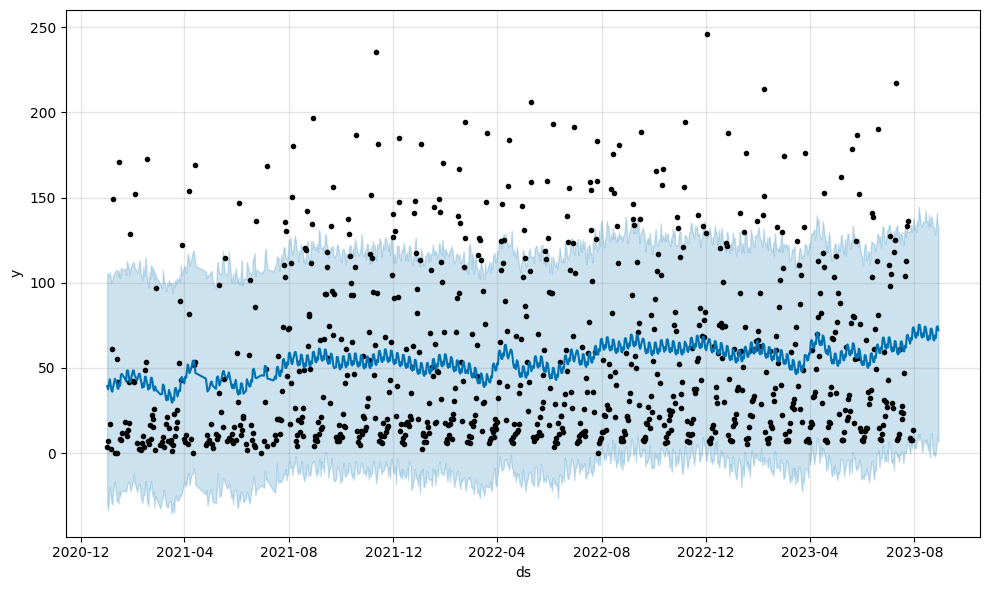

In [38]:
plot1 = model.plot(forecast)

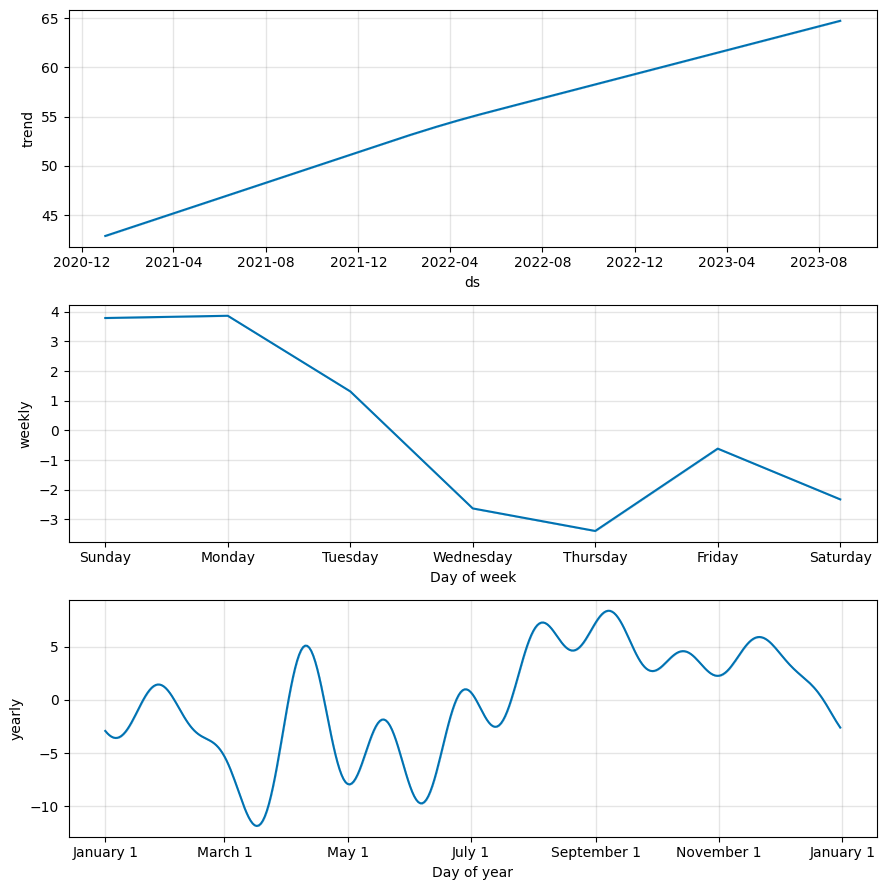

In [39]:
plot2 = model.plot_components(forecast)